In [1]:
!unzip Images.zip

'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms

In [3]:
import torchvision

In [4]:
if(torch.cuda.is_available()):
    device = torch.device("cuda")
    print(device, torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print(device)

cuda NVIDIA GeForce RTX 2060


# Read a batch of training image

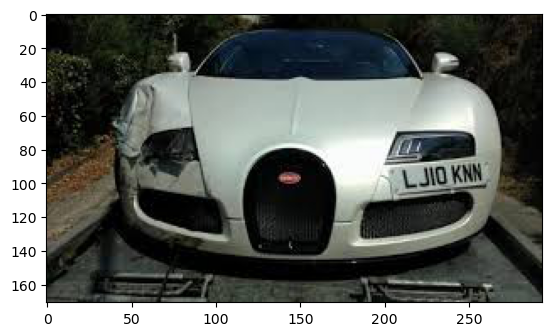

In [5]:
img0 = cv2.imread('0298.jpeg')
img0 = cv2.cvtColor(img0,cv2.COLOR_BGR2RGB)
plt.imshow(img0)

In [6]:
bbox0 = np.array([[40,30,120,80],[125,55,140,95]]) 
labels = np.array([1,1]) # 1: damage , 1: damage 0:background

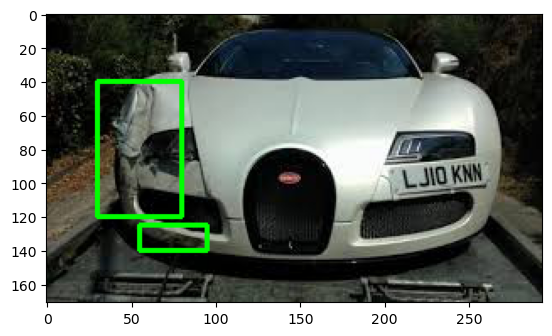

In [7]:
img0_copy = np.copy(img0)
for i in range(len(bbox0)):
    cv2.rectangle(img0_copy, (bbox0[i][1], bbox0[i][0]), (bbox0[i][3], bbox0[i][2]),color=(0,255,0),thickness=2)
plt.imshow(img0_copy)
plt.show()

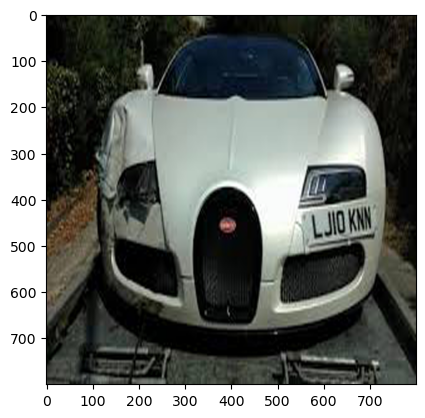

In [8]:
img = cv2.resize(img0,dsize=(800,800),interpolation= cv2.INTER_CUBIC)
plt.imshow(img)
plt.show()

In [9]:
Wratio = 800/img0.shape[1]
Hratio = 800/img0.shape[0]
ratioList = [Hratio,Wratio,Hratio,Wratio]
bbox = []
for box in bbox0:
    box = [int(a*b) for a,b in zip(box,ratioList)]
    bbox.append(box)
bbox = np.array(bbox)
print(bbox)

[[187  81 561 217]
 [584 149 654 258]]


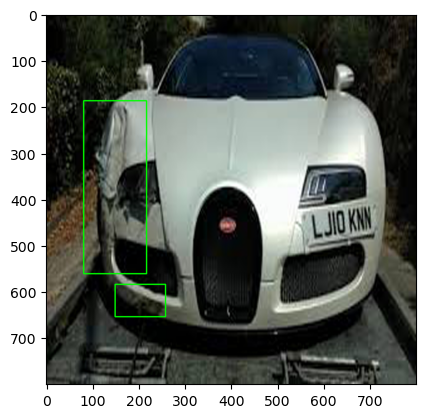

In [10]:
img_copy = np.copy(img)
bbox_copy = bbox.astype(int)
for i in range(len(bbox)):
    cv2.rectangle(img_copy, (bbox[i][1], bbox[i][0]), (bbox[i][3], bbox[i][2]),color=(0,255,0),thickness=2)
plt.imshow(img_copy)
plt.show()

# use VGG-16 to extract features

In [11]:
model = torchvision.models.vgg16(pretrained=True).to(device)
fe = list(model.features)
print(fe)
print("total layer:",len(fe))

C:\Users\62819\anaconda3\envs\computervision\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\62819\anaconda3\envs\computervision\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

we create dummy image just to test. from these 31 layer ,up to where our feature map size will be 50. because any further feature extraction layer will be terminated. 

In [12]:
dummy_imgs = torch.zeros((1,3,800,800)).float()
k = dummy_imgs.clone().to(device)
req_features = []

In [13]:
for i in fe:
    k = i(k) #first iteration-k is input from dummy image (dummy_imgs).
    
    if k.size()[2]< 800//16:#when our feature map size reach 50. we stop go deeper feature extraction 
        break
    
    req_features.append(i)
    out_channels = k.size()[1]
print(len(req_features))#before, we have 31 layer. because our feature map size reach 50 on 30th layer. so we terminated the last 31th layer.
print(out_channels)

30
512


In [14]:
faster_rcnn_fe_extractor = nn.Sequential(*req_features)

In [15]:
transform = transforms.Compose([transforms.ToTensor()])
imgTensor = transform(img).to(device)
imgTensor = imgTensor.unsqueeze(0)
out_map = faster_rcnn_fe_extractor(imgTensor)
print(out_map.size())

torch.Size([1, 512, 50, 50])


In [16]:
fe_size = (800//16)
center_x = np.arange(16,(fe_size+1)*16, 16) 
center_y = np.arange(16,(fe_size+1)*16, 16)
print(len(center_x),center_x)

50 [ 16  32  48  64  80  96 112 128 144 160 176 192 208 224 240 256 272 288
 304 320 336 352 368 384 400 416 432 448 464 480 496 512 528 544 560 576
 592 608 624 640 656 672 688 704 720 736 752 768 784 800]


In [17]:
#coordinates of the 2500 (50x50) center points to generate boxes
index = 0
center = np.zeros((2500,2))
for x in range(len(center_x)):
    for y in range(len(center_y)):
        center[index,1] = center_x[x]-8
        center[index,0] = center_y[y]-8
        index +=1
        
print(center.shape)

(2500, 2)


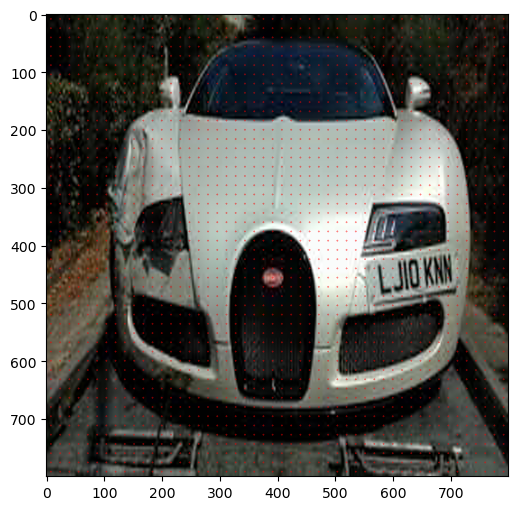

In [18]:
#display the image with center point (anchor boxes)
img_copy = np.copy(img)
plt.figure(figsize=(9,6))
for i in range(center.shape[0]):
    cv2.circle(img_copy,(int(center[i][0]),int(center[i][1])),radius=1,color=(255,0,0),thickness=1)
plt.imshow(img_copy)
plt.show()

In [19]:
#for each anchor, we generates 9 anchor boxes
#2500*9 = 22500 anchor boxes

ratios = [0.5, 1, 2]
scales = [8, 16, 32]
sub_sample = 16 #Since we have pooled our image from 800 px to 50px 800/50 = 16
anchor_boxes = np.zeros(((fe_size * fe_size * 9),4))
index = 0
for c in center:
    center_y,center_x = c
    for i in range(len(ratios)):
        for j in range(len(scales)):
            h = sub_sample * scales[j] * np.sqrt(ratios[i])
            w = sub_sample * scales[j] * np.sqrt(1/ ratios[i])
            anchor_boxes[index,0] = center_y - h / 2.
            anchor_boxes[index,1] = center_x - w / 2.
            anchor_boxes[index,2] = center_y + h / 2.
            anchor_boxes[index,3] = center_x + w / 2.
            index+=1
print(anchor_boxes.shape)

(22500, 4)


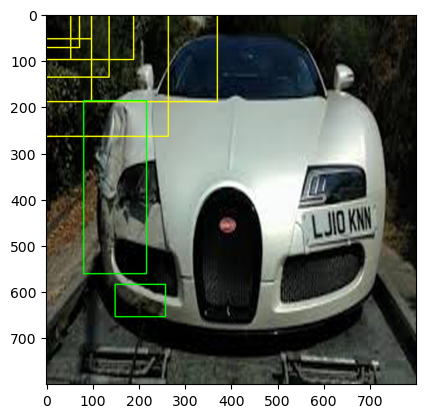

In [20]:
#display 9 anchor boxes, for the first anchor.
img_copy = np.copy(img)
for i in range(0,8):
    x0 = int(anchor_boxes[i][1])
    y0 = int(anchor_boxes[i][0])
    x1 = int(anchor_boxes[i][3])
    y1 = int(anchor_boxes[i][2])
    cv2.rectangle(img_copy,(x0,y0),(x1,y1),color=(255,255,0),thickness=2)
    
for i in range(len(bbox)):
    cv2.rectangle(img_copy, (bbox[i][1], bbox[i][0]), (bbox[i][3], bbox[i][2]),color=(0,255,0),thickness=2)

plt.imshow(img_copy)
plt.show()

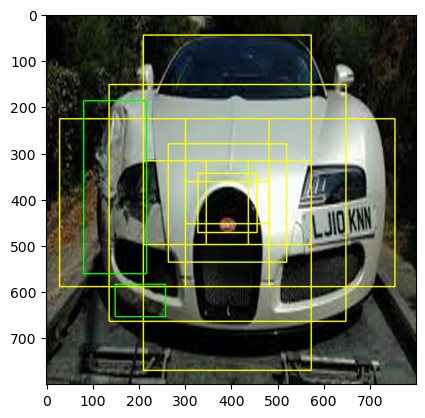

In [21]:
#display 9 anchor box for the center anchor.
img_copy = np.copy(img)
for i in range(11025,11034):
    x0 = int(anchor_boxes[i][1])
    y0 = int(anchor_boxes[i][0])
    x1 = int(anchor_boxes[i][3])
    y1 = int(anchor_boxes[i][2])
    cv2.rectangle(img_copy,(x0,y0),(x1,y1),color=(255,255,0),thickness=2)
    
    
for i in range(len(bbox)):
    cv2.rectangle(img_copy, (bbox[i][1], bbox[i][0]), (bbox[i][3], bbox[i][2]),color=(0,255,0),thickness=2)

plt.imshow(img_copy)
plt.show()

we filter which index are valid (valid index mean the index where the anchor boxes doesnt exceed the image).

In [22]:
#valid anchor boxes with (y1,x1)>0 and (y2,x2)<=800
index_valid = np.where(
    (anchor_boxes[:,0]>=0)&
        (anchor_boxes[:,1]>=0)&
         (anchor_boxes[:,2]<=800)&
         (anchor_boxes[:,3]<=800)
        )[0]

print(index_valid.shape)

(8940,)


In [23]:
#create an empty label array with inside_index shape and fill with -1. 
label = np.empty(len(index_valid), dtype=np.int32)
label.fill(-1)
print(label.shape)

(8940,)


In [24]:
valid_anchor_boxes = anchor_boxes[index_valid]
print(valid_anchor_boxes.shape)

(8940, 4)


In [25]:
'''since we have valid anchor boxes 8940 and the ground-truth boxes is 2. we should get ious an array shape (8940,2) 
because for each anchor boxes(8940) we calculate the intersection with each ground truth(2).'''

ious = np.empty((len(valid_anchor_boxes),2),dtype=np.float32)
ious.fill(0)

for num_i,i in enumerate(valid_anchor_boxes):
    
    ya1,xa1,ya2,xa2 = i
    
    #calculate area of anchor boxes
    anchor_area = (ya2-ya1)*(xa2-xa1)
    
    for num_j,j in enumerate(bbox):
        yb1,xb1,yb2,xb2 = j
        #calculate area of ground truth boxes
        box_area = (yb2-yb1)*(xb2-xb1)
        #we calculate coordinate of intersection area
        intersection_x1 = max([xb1,xa1])
        intersection_y1 = max([yb1,ya1])
        intersection_x2 = min([xb2,xa2])
        intersection_y2 = min([yb2,ya2])
        
        if(intersection_x1<intersection_x2) and (intersection_y1<intersection_y2):
            intersection_area = (intersection_y2-intersection_y1)*(intersection_x2-intersection_x1)
            iou = intersection_area /(anchor_area+box_area-intersection_area)
        else:
            iou = 0.
        ious[num_i,num_j] = iou
        
print(ious.shape)

(8940, 2)


In [26]:
#The anchor box that has max IOU that associated with ground truth boxes
#ex: we have 3 anchor box for a specific ground truth box. [0.3,0.5,0.8]. since the 3rd anchor box has IOU 0.8 we take that as gt_argmax_ious
gt_argmax_ious = ious.argmax(axis=0)
print(gt_argmax_ious)

gt_max_ious = ious[gt_argmax_ious,np.arange(ious.shape[1])]
print(gt_max_ious)

gt_argmax_ious = np.where(ious == gt_max_ious)[0]
print(gt_argmax_ious)

[ 589 1032]
[0.7331038  0.46569824]
[ 589  775  961 1032 1254 1478 1482 1484 1490 1495 1710 1938]


In [27]:
#for each anchor box , we tried to find which truth box that the anchor box has the max IOU with.
#ex: anchorbox-01 has 0.37 IOU with truth-box-1(labeled 0) and 0.55 with truth-box-2(labeled 1). then, the argmax_ious is 1.
#since our sample here only has 1 truth box. the argmax_ious will always return 0. 
argmax_ious = ious.argmax(axis=1)
print(argmax_ious)

#we make an array that store max iou of each anchor. 
max_ious = ious[np.arange(len(index_valid)),argmax_ious]
print(max_ious)

[0 0 0 ... 0 0 0]
[0.00226701 0.00713152 0.01204348 ... 0.         0.         0.        ]


In [28]:
#define the IOU values that we considered as positive and negative.
#first we only include highest value of iou to be consider as positive.here, we also consider iou value more than 0.7 as positive.
pos_iou_threshold  = 0.7
neg_iou_threshold = 0.3
#Assign positive label (1) to all the anchor boxes which have highest IoU overlap with a ground-truth box
label[gt_argmax_ious] = 1
#Assign positive label (1) to all the anchor boxes which have max_iou greater than positive threshold.
label[max_ious >= pos_iou_threshold] = 1
#Assign negitive label (0) to all the anchor boxes which have max_iou less than negitive threshold.
label[max_ious < neg_iou_threshold] = 0

In [29]:
unique, counts = np.unique(label, return_counts=True)

In [30]:
dict(zip(unique, counts))

{-1: 358, 0: 8567, 1: 15}

# mini-batch training  256 valid anchor boxes ( 128 positive examples, 128 negative examples )

In [31]:
n_sample = 256
pos_ratio = 0.5

n_pos = pos_ratio * n_sample
pos_index = np.where(label == 1)[0]

#we disabled some positive sample by change the label to -1, if the positive sample is more than maximum limit(n_pos).
if len(pos_index) > n_pos:
    disable_index = np.random.choice(pos_index, size=(len(pos_index) - n_pos), replace=False)
    label[disable_index] = -1

n_neg = n_sample * np.sum(label == 1)
neg_index = np.where(label == 0)[0]

#we disabled some negative sample by change the label to -1, if the negative sample is more than maximum limit(n_neg)
if len(neg_index) > n_neg:
    disable_index = np.random.choice(neg_index, size=(len(neg_index) - n_neg), replace = False)
    print("disable index for neg index processed")
    label[disable_index] = -1

disable index for neg index processed


In [32]:
unique, counts = np.unique(label, return_counts=True)

In [33]:
dict(zip(unique,counts))

{-1: 5085, 0: 3840, 1: 15}

# Assigning locations to anchor boxes (anchor_locs)

In [34]:
# For each valid anchor box, find the groundtruth object which has max_iou 

max_iou_bbox = bbox[argmax_ious]
print(max_iou_bbox)

[[187  81 561 217]
 [187  81 561 217]
 [187  81 561 217]
 ...
 [187  81 561 217]
 [187  81 561 217]
 [187  81 561 217]]


In [35]:
height = valid_anchor_boxes[:,2] - valid_anchor_boxes[:,0]
width = valid_anchor_boxes[:, 3] - valid_anchor_boxes[:, 1]
center_y = valid_anchor_boxes[:, 0] + (0.5 * height)
center_x = valid_anchor_boxes[:, 1] + (0.5 * width)

base_height = max_iou_bbox[:, 2] - max_iou_bbox[:, 0]
base_width = max_iou_bbox[:, 3] - max_iou_bbox[:, 1]
base_center_y = max_iou_bbox[:, 0] + (0.5 * base_height)
base_center_x = max_iou_bbox[:, 1] + (0.5 * base_width)

# valid anchor boxes 的 loc = (y-ya/ha), (x-xa/wa), log(h/ha), log(w/wa)
#eps is  the smallest possible positive number that the float datatype can represent
eps = np.finfo(height.dtype).eps
height = np.maximum(height, eps)  
width = np.maximum(width, eps)
dy = (base_center_y - center_y) / height
dx = (base_center_x - center_x) / width
#np.log is natural logarithm log(e) x
#log(e) x= ln x
dh = np.log(base_height / height)
dw = np.log(base_width / width)
anchor_locs = np.vstack((dy, dx, dh, dw)).transpose()
print(anchor_locs.shape)

(8940, 4)


In [36]:
#assign Final labels and final locations
#here final labels contain the fixed labels.
#we will map the label and anchor localtion for valid index that we calculate earlier above to the original anchors using the index_valid variable.
#what difference that we have between valid_anchor_boxes and our final locations is that .valid_anchor_boxes only has the valid one and final locations has both invalid and valid but the locations for invalid are  0.
anchor_labels = np.empty((len(anchor_boxes),), dtype=label.dtype)
anchor_labels.fill(-1)
anchor_labels[index_valid] = label
print(anchor_labels.shape)

anchor_locations = np.empty((len(anchor_boxes),) + anchor_boxes.shape[1:], dtype=anchor_locs.dtype)
anchor_locations.fill(0)
anchor_locations[index_valid, :] = anchor_locs
print(anchor_locations.shape)

(22500,)
(22500, 4)


# RPN

we use this RPN to generate 22500 ROI, 
we want to train this RPN to recognize the object we want.

the 22500(8940 valid) anchor box with label that we generate earlier is y-actual 
and the 22500 ROI generated by RPN is y-pred.

In [37]:
in_channels = 512 # depends on the output feature map. in vgg-16 it is equal to 512
mid_channels = 512
n_anchor = 9  # Number of anchors at each location

conv1 = nn.Conv2d(in_channels, mid_channels, 3, 1, 1).to(device)
conv1.weight.data.normal_(0, 0.01)
conv1.bias.data.zero_()

reg_layer = nn.Conv2d(mid_channels, n_anchor *4, 1, 1, 0).to(device)
reg_layer.weight.data.normal_(0, 0.01)
reg_layer.bias.data.zero_()

cls_layer = nn.Conv2d(mid_channels, n_anchor *2, 1, 1, 0).to(device) #I will be going to use softmax here. you can equally use sigmoid if u replace 2 with 1.
cls_layer.weight.data.normal_(0, 0.01)
cls_layer.bias.data.zero_()

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')

In [38]:
conv1.weight.data.normal_(0, 0.01)
conv1.bias.data.zero_()
# Regression layer
reg_layer.weight.data.normal_(0, 0.01)
reg_layer.bias.data.zero_()
# classification layer
cls_layer.weight.data.normal_(0, 0.01)
cls_layer.bias.data.zero_()

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')

In [39]:
x = conv1(out_map) # out_map is obtained in section 1
pred_anchor_locs = reg_layer(x)
pred_cls_scores = cls_layer(x)
print(pred_cls_scores.shape, pred_anchor_locs.shape)
#Out:
#torch.Size([1, 18, 50, 50]) torch.Size([1, 36, 50, 50])

torch.Size([1, 18, 50, 50]) torch.Size([1, 36, 50, 50])


In [40]:
pred_anchor_locs = pred_anchor_locs.permute(0, 2, 3, 1).contiguous().view(1, -1, 4)
print(pred_anchor_locs.shape)

pred_cls_scores = pred_cls_scores.permute(0, 2, 3, 1).contiguous()
print(pred_cls_scores.shape)

objectness_score = pred_cls_scores.view(1, 50, 50, 9, 2)[:, :, :, :, 1].contiguous().view(1, -1)
print(objectness_score.shape)

pred_cls_scores  = pred_cls_scores.view(1, -1, 2)
print(pred_cls_scores.shape)

torch.Size([1, 22500, 4])
torch.Size([1, 50, 50, 18])
torch.Size([1, 22500])
torch.Size([1, 22500, 2])


## RPN loss

In [41]:
print(pred_anchor_locs.shape)
print(pred_cls_scores.shape)
print(anchor_locations.shape)
print(anchor_labels.shape)

torch.Size([1, 22500, 4])
torch.Size([1, 22500, 2])
(22500, 4)
(22500,)


In [42]:
rpn_loc = pred_anchor_locs[0]
rpn_score = pred_cls_scores[0]
gt_rpn_loc = torch.from_numpy(anchor_locations)
gt_rpn_score = torch.from_numpy(anchor_labels)
print(rpn_loc.shape, rpn_score.shape, gt_rpn_loc.shape, gt_rpn_score.shape)

torch.Size([22500, 4]) torch.Size([22500, 2]) torch.Size([22500, 4]) torch.Size([22500])


In [43]:
rpn_score

tensor([[ 0.0030,  0.0339],
        [-0.0048, -0.0123],
        [-0.0092,  0.0080],
        ...,
        [ 0.0197, -0.0090],
        [ 0.0128,  0.0051],
        [-0.0141, -0.0129]], device='cuda:0', grad_fn=<SelectBackward0>)

In [44]:
gt_rpn_score

tensor([-1, -1, -1,  ..., -1, -1, -1], dtype=torch.int32)

In [45]:
import torch.nn.functional as F
#F.cross_entropy already calculate softmax before we go for cross_entropy
rpn_cls_loss = F.cross_entropy(rpn_score.cpu(), gt_rpn_score.long().cpu(), ignore_index = -1)
print(rpn_cls_loss)

tensor(0.6943, grad_fn=<NllLossBackward0>)


In [46]:
pos = gt_rpn_score > 0
pos_loc_preds = rpn_loc[pos].view(-1,4).cpu()
pos_loc_targets = gt_rpn_loc[pos].view(-1,4).cpu()
print(pos_loc_preds.shape, pos_loc_targets.shape)

torch.Size([15, 4]) torch.Size([15, 4])


In [47]:
x = torch.abs(pos_loc_targets - pos_loc_preds)
rpn_loc_loss = ((x<1).float() * 0.5 * x**2)+((x>=1).float()*(x-0.5))
print(rpn_loc_loss.sum())

tensor(1.6490, dtype=torch.float64, grad_fn=<SumBackward0>)


In [48]:
rpn_lambda = 10.
N_reg = sum([float(value) for value in(gt_rpn_score>0)])
#rpn_loc_loss averaging
rpn_loc_loss = rpn_loc_loss.sum()/N_reg
#the reason we only do averaging on rpn_loc_loss but not with rpn_cls_los, because rpn_cls_los which is come from cross_entropy.(cross entropy automatically averaging the return)
rpn_loss = rpn_cls_loss + (rpn_lambda * rpn_loc_loss)
print(rpn_loss)

tensor(1.7936, dtype=torch.float64, grad_fn=<AddBackward0>)


# Region proposal  

RPN proposals highly overlap with each other. To reduced redundancy, we adopt non-maximum supression (NMS) on the proposal regions based on their cls scores. We fix the IoU threshold for NMS at 0.7, which leaves us about 2000 proposal regions per image. we use the top-N ranked proposal regions for detection.

In [49]:
nms_thresh = 0.7
n_train_pre_nms = 12000
n_train_post_nms = 2000
n_test_pre_nms = 6000
n_test_post_nms = 300
min_size = 4

## 1.convert the loc predictions from the rpn network to bbox [y1, x1, y2, x2] format. 

This is the reverse operations of what we have done while assigning ground truth to anchor boxes .
what we done before is tried to find the anchor_locs(the location of ground truth in respect of specific anchor box).
now , from the prediction we got the pred_locs and we tried to find the predicted boxes .

Convert anchors format from coordinate (y1, x1, y2, x2) to length and center (ctr_x, ctr_y, h, w)

In [50]:
anc_height = anchor_boxes[:, 2] - anchor_boxes[:, 0]
anc_width = anchor_boxes[:, 3] - anchor_boxes[:, 1]
anc_ctr_y = anchor_boxes[:, 0] + 0.5 * anc_height
anc_ctr_x = anchor_boxes[:, 1] + 0.5 * anc_width

Convert predictions locs using above formulas. before that convert the pred_anchor_locs and objectness_score to numpy array

In [51]:
pred_anchor_locs_numpy = pred_anchor_locs[0].cpu().data.numpy()
objectness_score_numpy = objectness_score[0].cpu().data.numpy()

dy = pred_anchor_locs_numpy[:, 0::4]
dx = pred_anchor_locs_numpy[:, 1::4]
dh = pred_anchor_locs_numpy[:, 2::4]
dw = pred_anchor_locs_numpy[:, 3::4]

ctr_y = dy * anc_height[:, np.newaxis] + anc_ctr_y[:, np.newaxis]
ctr_x = dx * anc_width[:, np.newaxis] + anc_ctr_x[:, np.newaxis]

h = np.exp(dh) * anc_height[:, np.newaxis]
w = np.exp(dw) * anc_width[:, np.newaxis]

convert center and length format [ctr_x, ctr_y, h, w] to coordinate [y1, x1, y2, x2] format

In [52]:
roi = np.zeros(pred_anchor_locs_numpy.shape, dtype=anchor_locs.dtype)
'''
roi structure {y_min,x_min,y_max,x_max}
'''
roi[:, 0::4] = ctr_y - 0.5 * h
roi[:, 1::4] = ctr_x - 0.5 * w
roi[:, 2::4] = ctr_y + 0.5 * h
roi[:, 3::4] = ctr_x + 0.5 * w 

## 2.clip the predicted boxes to the image

In [53]:
img_size = (800, 800) #Image size
#we normalize anchor boxes that goes beyond image-size(800,800) ,if one of predicted box coordinates smaller than 0 or bigger 800.
#smaller than 0 or bigger than 800 mean our coordinate is already out of image frame. 
#example: if one of predicted box has coordinate (-1,-1) we will clipped it to (0,0)
roi[:, slice(0, 4, 2)] = np.clip(roi[:, slice(0, 4, 2)], 0, img_size[0])
roi[:, slice(1, 4, 2)] = np.clip(roi[:, slice(1, 4, 2)], 0, img_size[1])
print(roi)

[[  0.           0.          52.9459094  103.60585789]
 [  0.           0.         101.46348233 187.58215475]
 [  0.           0.         181.64625937 366.40989305]
 ...
 [704.91445527 744.7015336  800.         800.        ]
 [615.33422273 704.22041503 800.         800.        ]
 [407.72369993 604.82484368 800.         800.        ]]


In [54]:
roi[:, slice(0, 4, 2)] = np.clip(roi[:, slice(0, 4, 2)], 0, img_size[0])
roi[:, slice(1, 4, 2)] = np.clip(roi[:, slice(1, 4, 2)], 0, img_size[1])

'''
we can use numpy slicing too. the result will be the same
roi[:, 0:4:2] = np.clip(roi[:, 0:4:2], 0, img_size[0])
roi[:, 1:4:2] = np.clip(roi[:, 1:4:2], 0,img_size[1])
'''

'\nwe can use numpy slicing too. the result will be the same\nroi[:, 0:4:2] = np.clip(roi[:, 0:4:2], 0, img_size[0])\nroi[:, 1:4:2] = np.clip(roi[:, 1:4:2], 0,img_size[1])\n'

## 3.Remove predicted boxes with height and width < threshold.

In [55]:
hs = roi[:, 2] - roi[:, 0]
ws = roi[:, 3] - roi[:, 1]
keep = np.where((hs >= min_size) & (ws >= min_size))[0]
roi = roi[keep, :]
score = objectness_score_numpy[keep]

## 4.Sort all (proposal, score) pairs by score from highest to lowest.

In [56]:
len(score)

22500

In [57]:
#sort the index based on score from highest to lowest
order = score.ravel().argsort()[::-1]
print(order)

[16494 12381 12372 ... 17262 14312 10737]


## 5.Take top of  pre_nms_topN 

In [58]:
#we slice the order that already been sorted from highest to lowest.
order = order[:n_train_pre_nms]

#we take all the roi based on index from order.
roi = roi[order, :]

print(roi.shape)
print(roi)

(12000, 4)
[[439.68842219 530.19215936 620.50025272 628.11745004]
 [360.32245995 385.40334131 505.58369215 483.06790146]
 [352.42049204 393.84714209 491.30057538 490.33461157]
 ...
 [  0.         276.12162757 251.57223272 791.98405433]
 [  0.          53.32988917 385.11039094 428.68214231]
 [171.08685589   0.         436.16675091 181.98894715]]


## 6.Apply non-maximum supression(NMS) threshold

In [59]:
y1 = roi[:, 0]
x1 = roi[:, 1]
y2 = roi[:, 2]
x2 = roi[:, 3]

In [60]:
area = (x2 - x1 + 1) * (y2 - y1 + 1)
#the element of order is actually an indices of score from highest to lowest that we will use in roi index.
#when we slice it to only get the top 12000 of score indices , there raise a problem.
#the problem is since roi only has len 12000,and our order contain element >12000. there will raise an error.
#because element in order is indices for roi. if we contain element >12000 it will raise error when we initiate roi[order].
#so, we need to normalize the order.
#to normalize the order we apply argsort again.
#when we apply argsort()[:-1] once again ,we Returns the indices that sort the element of array.(those indices will be inrange between 0-12000)
#after we do this, our order will not sorted from highest to lowest but will be random.but, we don't care since we already slice the top highest 12000.
order = order.argsort()[::-1]

In [61]:
order

array([ 9088, 11591,  6696, ...,  7992,  8287,  3284], dtype=int64)

In [62]:
#by calling max(), we confirm that maximum element of order is <12000
max(order)

11999

### we will reduce the roi to 2000, by eliminate roi that highly overlapping each other.

In [63]:
keep = []
m = 0
while (order.size > 0):

    i = order[0] #take the 1st elt in order and append to keep 
    keep.append(i)
    #calculate intersection with each other 
    #because we are tried to remove roi that highly overlap with each other.
    #we tried to find intersect of area that we defined(i =order[0]) with all of other area(order[1:]) 
    xx1 = np.maximum(x1[i], x1[order[1:]])#x1[order[1:]] is an array
    yy1 = np.maximum(y1[i], y1[order[1:]])#y1[order[1:]] is an array
    xx2 = np.minimum(x2[i], x2[order[1:]])#x2[order[1:]] is an array
    yy2 = np.minimum(y2[i], y2[order[1:]])#y2[order[1:]] is an array
    w = np.maximum(0.0, xx2 - xx1 + 1)
    h = np.maximum(0.0, yy2 - yy1 + 1)
    inter = w * h #intersection
    #ovr is overlaid
    #Its almost same as IOU, the difference is ovr is intersection with each other boxes divided by total area
    #whereas IOU is intersection between box and ground truth box divided by total area.
    ovr = inter / (area[i] + area[order[1:]] - inter)
    
    '''
    inds is index of order that hold the condition and order is index of roi.
        ex: inds=[0,1,2,3]
            order = [1134,102,5002,1045]
            we use inds for order (order[inds[0]])
    '''
    
    inds = np.where(ovr <= nms_thresh)[0]#inds tell us which indices hold the condition.(here we eliminate iou that highly overlapped)
    print(inds)
    
    '''
    example:
    iteration-1:
    our first order is = [1134,102,5002,1045,84,344]
        we calculate intersection roi from i with all other roi.
        we got inds = [0,1,2,4] 
        inds+1 = [1,2,3,5]
        order = order[1,2,3,5] 
        so, now our new order for next iteration(iteration-1) is order from index 1,2,3,5.
        so the order for next iteration is [102,5002,1045,344]
    iteration-2:
        our second order is = [102,5002,1045,344]
        i = order[0] which mean i = 102.
        we calculate intersection roi from i with all other roi.
        we got inds = [0,1,2]
        inds+1 = [1,2,3]
        order = order[1,2,3]
        so, our new order for next iteration(iteration-2) is order from index 1,2,3.
        so the order for next iteration is [5002,1045,344]
    '''
    order = order[inds + 1] 
    
keep = keep[:n_train_post_nms] # while training/testing , use accordingly
roi = roi[keep] # the final region proposals
print(len(keep), roi.shape)

[    0     1     2 ... 11996 11997 11998]
[    0     1     2 ... 11981 11982 11983]
[    0     1     2 ... 11956 11957 11958]
[    0     1     3 ... 11952 11953 11954]
[    0     2     3 ... 11897 11898 11899]
[    1     2     3 ... 11889 11890 11891]
[    0     1     2 ... 11886 11887 11888]
[    0     1     3 ... 11871 11872 11873]
[    0     1     2 ... 11822 11823 11824]
[    0     1     2 ... 11819 11820 11821]
[    0     1     3 ... 11811 11812 11813]
[    0     1     2 ... 11756 11757 11758]
[    0     1     2 ... 11754 11755 11756]
[    0     2     3 ... 11749 11750 11751]
[    1     2     3 ... 11745 11746 11747]
[    0     1     2 ... 11740 11741 11742]
[    0     1     3 ... 11736 11737 11738]
[    0     2     3 ... 11734 11735 11736]
[    0     1     2 ... 11732 11733 11734]
[    0     1     2 ... 11730 11731 11732]
[    0     2     3 ... 11728 11729 11730]
[    0     2     3 ... 11726 11727 11728]
[    0     1     3 ... 11715 11716 11717]
[    0     1     2 ... 11621 11622

[   0    2    3 ... 9789 9790 9791]
[   0    2    3 ... 9783 9784 9785]
[   1    2    3 ... 9780 9781 9782]
[   0    1    2 ... 9778 9779 9780]
[   0    1    2 ... 9774 9775 9776]
[   0    1    2 ... 9766 9767 9768]
[   1    2    3 ... 9765 9766 9767]
[   1    2    3 ... 9763 9764 9765]
[   0    1    2 ... 9761 9762 9763]
[   0    2    3 ... 9759 9760 9761]
[   0    2    3 ... 9756 9757 9758]
[   1    2    3 ... 9697 9698 9699]
[   1    2    3 ... 9695 9696 9697]
[   0    2    3 ... 9690 9691 9692]
[   1    2    3 ... 9685 9686 9687]
[   0    1    2 ... 9682 9683 9684]
[   0    1    2 ... 9681 9682 9683]
[   0    1    2 ... 9650 9651 9652]
[   0    1    2 ... 9648 9649 9650]
[   0    1    2 ... 9646 9647 9648]
[   0    1    2 ... 9645 9646 9647]
[   1    2    3 ... 9637 9638 9639]
[   0    1    2 ... 9635 9636 9637]
[   0    3    4 ... 9600 9601 9602]
[   0    1    2 ... 9595 9596 9597]
[   0    1    2 ... 9594 9595 9596]
[   1    2    3 ... 9592 9593 9594]
[   0    1    2 ... 9590 959

[   0    1    2 ... 8151 8152 8153]
[   1    2    3 ... 8149 8150 8151]
[   0    1    2 ... 8144 8145 8146]
[   0    1    2 ... 8142 8143 8144]
[   0    1    2 ... 8140 8141 8142]
[   0    3    5 ... 8138 8139 8140]
[   0    1    2 ... 8129 8130 8131]
[   2    3    4 ... 8127 8128 8129]
[   0    1    2 ... 8121 8122 8123]
[   0    1    2 ... 8115 8116 8117]
[   0    1    2 ... 8113 8114 8115]
[   1    2    3 ... 8111 8112 8113]
[   1    2    3 ... 8107 8108 8109]
[   0    2    3 ... 8102 8103 8104]
[   1    2    3 ... 8093 8094 8095]
[   0    1    2 ... 8091 8092 8093]
[   0    1    2 ... 8085 8086 8087]
[   0    1    2 ... 8082 8083 8084]
[   0    1    2 ... 8081 8082 8083]
[   0    2    3 ... 8080 8081 8082]
[   0    1    2 ... 8072 8073 8074]
[   0    1    2 ... 8069 8070 8071]
[   0    2    3 ... 8067 8068 8069]
[   1    2    3 ... 8065 8066 8067]
[   0    1    2 ... 8062 8063 8064]
[   0    1    2 ... 8060 8061 8062]
[   0    1    2 ... 8058 8059 8060]
[   0    2    3 ... 8056 805

[   0    1    2 ... 6640 6641 6642]
[   0    1    2 ... 6631 6632 6633]
[   0    1    2 ... 6629 6630 6631]
[   1    2    3 ... 6627 6628 6629]
[   0    2    4 ... 6621 6622 6623]
[   0    1    2 ... 6617 6618 6619]
[   1    2    3 ... 6614 6615 6616]
[   0    1    2 ... 6607 6608 6609]
[   0    1    2 ... 6605 6606 6607]
[   0    1    2 ... 6603 6604 6605]
[   0    1    2 ... 6600 6601 6602]
[   0    2    3 ... 6599 6600 6601]
[   0    2    3 ... 6589 6590 6591]
[   0    2    3 ... 6587 6588 6589]
[   0    1    2 ... 6584 6585 6586]
[   0    1    2 ... 6579 6580 6581]
[   0    1    2 ... 6577 6578 6579]
[   0    1    2 ... 6569 6570 6571]
[   1    2    3 ... 6567 6568 6569]
[   0    1    2 ... 6564 6565 6566]
[   1    2    3 ... 6562 6563 6564]
[   0    2    3 ... 6560 6561 6562]
[   1    2    3 ... 6554 6555 6556]
[   0    1    2 ... 6551 6552 6553]
[   2    3    4 ... 6550 6551 6552]
[   0    1    2 ... 6547 6548 6549]
[   0    2    3 ... 6545 6546 6547]
[   2    3    4 ... 6507 650

[   0    2    3 ... 5085 5086 5087]
[   0    1    2 ... 5083 5084 5085]
[   1    2    3 ... 5081 5082 5083]
[   0    1    2 ... 5079 5080 5081]
[   0    1    2 ... 5077 5078 5079]
[   0    1    2 ... 5076 5077 5078]
[   0    1    2 ... 5074 5075 5076]
[   0    3    4 ... 5069 5070 5071]
[   0    1    2 ... 5066 5067 5068]
[   0    1    2 ... 5064 5065 5066]
[   0    1    2 ... 5061 5062 5063]
[   0    1    2 ... 5046 5047 5048]
[   0    1    2 ... 5043 5044 5045]
[   0    1    3 ... 5041 5042 5043]
[   0    1    2 ... 5037 5038 5039]
[   1    2    3 ... 5027 5028 5029]
[   1    2    3 ... 5022 5023 5024]
[   0    2    3 ... 5019 5020 5021]
[   0    1    2 ... 5016 5017 5018]
[   0    1    2 ... 5015 5016 5017]
[   0    1    2 ... 5014 5015 5016]
[   0    1    2 ... 5013 5014 5015]
[   0    1    2 ... 4989 4990 4991]
[   0    2    3 ... 4988 4989 4990]
[   1    2    3 ... 4985 4986 4987]
[   0    2    3 ... 4983 4984 4985]
[   0    1    2 ... 4981 4982 4983]
[   0    1    2 ... 4979 498

[   0    2    3 ... 3885 3886 3887]
[   0    2    3 ... 3881 3882 3883]
[   0    2    3 ... 3870 3871 3872]
[   0    1    2 ... 3868 3869 3870]
[   0    1    2 ... 3866 3867 3868]
[   0    1    3 ... 3831 3832 3833]
[   0    1    2 ... 3828 3829 3830]
[   1    2    3 ... 3827 3828 3829]
[   0    1    3 ... 3825 3826 3827]
[   0    1    2 ... 3818 3819 3820]
[   0    1    2 ... 3816 3817 3818]
[   0    2    3 ... 3815 3816 3817]
[   1    2    3 ... 3813 3814 3815]
[   0    1    2 ... 3808 3809 3810]
[   0    1    3 ... 3806 3807 3808]
[   0    1    2 ... 3797 3798 3799]
[   0    1    2 ... 3793 3794 3795]
[   0    1    2 ... 3791 3792 3793]
[   0    1    2 ... 3789 3790 3791]
[   0    1    2 ... 3788 3789 3790]
[   0    1    2 ... 3753 3754 3755]
[   0    2    3 ... 3751 3752 3753]
[   0    1    2 ... 3749 3750 3751]
[   0    1    2 ... 3748 3749 3750]
[   0    1    2 ... 3737 3738 3739]
[   0    2    4 ... 3736 3737 3738]
[   2    3    4 ... 3729 3730 3731]
[   0    1    3 ... 3726 372

[   1    2    3 ... 2741 2742 2743]
[   0    1    2 ... 2738 2739 2740]
[   0    1    2 ... 2737 2738 2739]
[   1    2    3 ... 2736 2737 2738]
[   0    1    2 ... 2734 2735 2736]
[   0    2    3 ... 2732 2733 2734]
[   0    2    3 ... 2729 2730 2731]
[   0    1    2 ... 2721 2722 2723]
[   0    1    2 ... 2720 2721 2722]
[   0    1    2 ... 2719 2720 2721]
[   0    1    2 ... 2717 2718 2719]
[   0    2    3 ... 2716 2717 2718]
[   0    2    3 ... 2713 2714 2715]
[   0    1    2 ... 2711 2712 2713]
[   0    1    3 ... 2706 2707 2708]
[   0    2    3 ... 2702 2703 2704]
[   0    1    2 ... 2694 2695 2696]
[   0    1    2 ... 2692 2693 2694]
[   0    1    2 ... 2689 2690 2691]
[   0    2    3 ... 2687 2688 2689]
[   0    1    2 ... 2681 2682 2683]
[   0    1    2 ... 2679 2680 2681]
[   0    1    2 ... 2677 2678 2679]
[   0    1    3 ... 2675 2676 2677]
[   0    1    3 ... 2672 2673 2674]
[   0    1    2 ... 2670 2671 2672]
[   0    2    3 ... 2668 2669 2670]
[   0    1    2 ... 2663 266

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235
 236 237 238 239 240 241 242 243 244 245 246 247 24

[  0   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163
 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181
 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199
 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217
 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235
 236 237 238 239 240 241 242 243 244 245 246 247 24

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  76  77  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163
 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181
 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 198 199 200
 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218
 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236
 237 238 239 240 241 242 243 244 245 246 247 248 24

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  

In [64]:
roi

array([[6.15334223e+02, 7.04220415e+02, 8.00000000e+02, 8.00000000e+02],
       [5.24740229e+02, 5.36687487e+02, 8.00000000e+02, 8.00000000e+02],
       [7.24755591e+02, 7.31802350e+02, 8.00000000e+02, 8.00000000e+02],
       ...,
       [6.65662034e+02, 5.41952773e+01, 8.00000000e+02, 3.09916652e+02],
       [3.99844219e+02, 1.31725538e-01, 8.00000000e+02, 3.68463665e+02],
       [6.02440184e+02, 8.99332450e+01, 8.00000000e+02, 2.77050320e+02]])

# Proposal targets

In [65]:
n_sample = 128
pos_ratio = 0.25
pos_iou_thresh = 0.5
neg_iou_thresh_hi = 0.5
neg_iou_thresh_lo = 0.0

In [66]:
#we will calculate how much iou each final proposal-region has and stored it in ious
ious = np.empty((len(roi), 2), dtype=np.float32)
ious.fill(0)
for num1, i in enumerate(roi):
    ya1, xa1, ya2, xa2 = i  
    anchor_area = (ya2 - ya1) * (xa2 - xa1)
    for num2, j in enumerate(bbox):
        yb1, xb1, yb2, xb2 = j
        box_area = (yb2- yb1) * (xb2 - xb1)
        inter_x1 = max([xb1, xa1])
        inter_y1 = max([yb1, ya1])
        inter_x2 = min([xb2, xa2])
        inter_y2 = min([yb2, ya2])
        if (inter_x1 < inter_x2) and (inter_y1 < inter_y2):
            iter_area = (inter_y2 - inter_y1) * (inter_x2 - inter_x1)
            iou = iter_area / (anchor_area+ box_area - iter_area)            
        else:
            iou = 0.
        ious[num1, num2] = iou
print(ious.shape)

(2000, 2)


In [67]:
gt_assignment = ious.argmax(axis=1)#which ground truth each region proposal has the maximum iou with.
#it will return 0 if it overlap more with ground truth-1.
#it will return 1 if it overlap more with ground truth-2.
#if the roi doesnt overlap with any of ground truth it will return 0.
max_iou = ious.max(axis=1)#IOU each region proposal has maximum iou with.
print(gt_assignment)
print(max_iou)

[0 0 0 ... 0 0 1]
[0.         0.         0.         ... 0.         0.1242915  0.14418887]


In [68]:
# n_sample x pos_ratio (128 x 0.25 = 32)
#incase if we get less than 32 positive samples we will just let it be, but if we get more than 32 foreground samples, we will only sample 32 samples from the positive samples. 
pos_roi_per_image = 32
pos_index = np.where(max_iou >= pos_iou_thresh)[0]
pos_roi_per_this_image = int(min(pos_roi_per_image, pos_index.size))
if pos_index.size > 0:
    pos_index = np.random.choice(pos_index, size = pos_roi_per_this_image, replace=False)
print(pos_roi_per_this_image)
print(pos_index)

0
[]


In [69]:
# Similarly we do for negitive (background) region proposals
neg_index = np.where((max_iou < neg_iou_thresh_hi) &
                             (max_iou >= neg_iou_thresh_lo))[0]
neg_roi_per_this_image = n_sample - pos_roi_per_this_image
neg_roi_per_this_image = int(min(neg_roi_per_this_image, neg_index.size))
if  neg_index.size > 0 :
    neg_index = np.random.choice(neg_index, size=neg_roi_per_this_image, replace=False)
print(neg_roi_per_this_image)
print(neg_index)

128
[1854  378 1441  534  723  955 1542 1426 1944 1695  579 1241 1922  269
 1438  946 1296  538 1292  659  758 1753  762 1829  712 1045  866 1274
 1179 1943 1766 1668 1381 1303  936 1987 1794  410  423   77  564 1498
  968  122 1930  240 1963 1940  841  177 1332 1894 1497 1237 1983 1639
  349  359  456 1880  794    6 1590  614 1575 1730  575 1815  443  413
  136 1808  976 1293 1473 1038 1467 1615  984 1991 1624 1408 1132  580
 1271  258 1965  516  655    4  947  764  677 1966 1275 1691 1002 1715
 1537 1356 1663 1680   11 1649 1262 1559 1807  827   31  861  681 1923
  931  850 1086 1100  954   56 1051  184 1163   98 1425 1310  826 1185
  109  422]


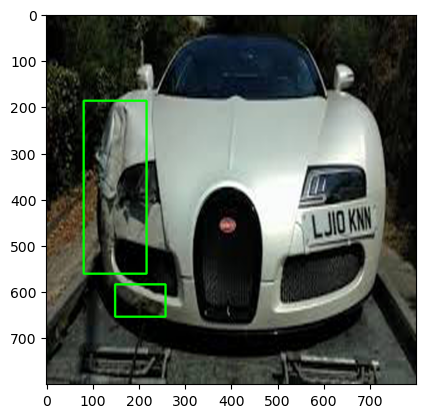

In [70]:
img_clone = np.copy(img)
for i in range(pos_roi_per_this_image):
    y0,x0,y1,x1 = roi[pos_index[i]].astype(int)
    cv2.rectangle(img_clone,(x0,y0),(x1,y1),(255,255,255),thickness=3)
    
for i in range(len(bbox)):
    cv2.rectangle(img_clone,(bbox[i][1],bbox[i][0]),(bbox[i][3],bbox[i][2]), color=(0,255,0),thickness=3)

plt.imshow(img_clone)
plt.show()

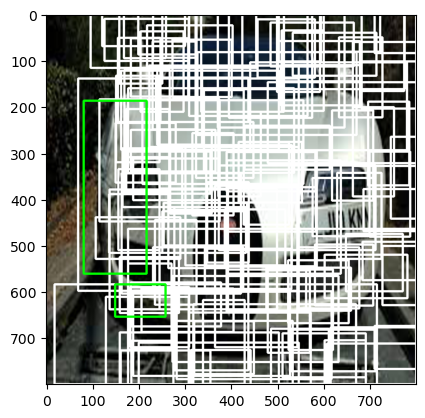

In [71]:
img_clone = np.copy(img)
for i in range(neg_roi_per_this_image):
    y0,x0,y1,x1 = roi[neg_index[i]].astype(int)
    cv2.rectangle(img_clone,(x0,y0),(x1,y1),(255,255,255),thickness=3)
    
for i in range(len(bbox)):
    cv2.rectangle(img_clone,(bbox[i][1],bbox[i][0]),(bbox[i][3],bbox[i][2]), color=(0,255,0),thickness=3)

plt.imshow(img_clone)
plt.show()

In [72]:
gt_roi_label = labels[gt_assignment]
print(gt_roi_label)

[1 1 1 ... 1 1 1]


In [73]:
#we gather postive and negative index together.
keep_index = np.append(pos_index, neg_index)
gt_roi_labels = gt_roi_label[keep_index]
gt_roi_labels[pos_roi_per_this_image:] = 0  # negative labels --> 0
sample_roi = roi[keep_index]
print(sample_roi.shape)

(128, 4)


In [74]:
#pick the ground truth objects for these roi that we keep.
bbox_for_sampled_roi = bbox[gt_assignment[keep_index]]
print(bbox_for_sampled_roi.shape)

height = sample_roi[:, 2] - sample_roi[:, 0]
width = sample_roi[:, 3] - sample_roi[:, 1]
ctr_y = sample_roi[:, 0] + 0.5 * height
ctr_x = sample_roi[:, 1] + 0.5 * width

base_height = bbox_for_sampled_roi[:, 2] - bbox_for_sampled_roi[:, 0]
base_width = bbox_for_sampled_roi[:, 3] - bbox_for_sampled_roi[:, 1]
base_ctr_y = bbox_for_sampled_roi[:, 0] + 0.5 * base_height
base_ctr_x = bbox_for_sampled_roi[:, 1] + 0.5 * base_width

(128, 4)


In [75]:
#we transform our prediction back to the originate(dy,dx,dh,dw)
eps = np.finfo(height.dtype).eps
height = np.maximum(height, eps)
width = np.maximum(width, eps)
dy = (base_ctr_y - ctr_y) / height
dx = (base_ctr_x - ctr_x) / width
dh = np.log(base_height / height)
dw = np.log(base_width / width)
gt_roi_locs = np.vstack((dy, dx, dh, dw)).transpose()
print(gt_roi_locs)

[[ 1.59664336e-01 -6.29778231e-01  1.08347355e+00  5.68619542e-02]
 [ 1.36803800e+00 -5.69003863e+00  7.70032161e-01  3.75644500e-01]
 [ 2.07964417e+00 -1.47315872e+00  1.10897684e+00  5.99697812e-02]
 [-3.93988676e+00 -2.54932341e+00  1.42689759e+00 -3.10413929e-01]
 [-3.08215534e+00 -3.18161894e+00  1.14785753e+00  7.85600397e-02]
 [ 3.85295191e-01 -1.76249323e+00  1.47331023e+00 -3.41718617e-01]
 [ 1.83177663e-01 -1.82983546e+00  7.28480724e-01  4.11435949e-01]
 [-8.72414500e-01 -1.08567180e+00  1.40308767e+00 -2.79088179e-01]
 [ 3.42770741e+00 -7.11011787e-01  1.36805590e+00  3.95147529e-01]
 [-5.40666039e+00 -5.65421155e-01  1.64589704e+00 -3.52819126e-01]
 [-3.99705609e-02 -4.58567295e-01 -1.56624245e+00 -1.74204687e+00]
 [-1.85718940e+00 -2.64092479e+00  7.29572963e-01  4.22281640e-01]
 [ 5.74551597e-01 -5.11626844e-01  1.06842142e+00  4.28010915e-02]
 [ 3.94319964e-01 -6.30411050e+00  6.64617886e-01  4.27746362e-01]
 [ 9.69300311e-01 -5.38180660e-01  7.81624479e-01 -9.19175512e

# FAST R-CNN

In [76]:
rois = torch.from_numpy(sample_roi).float()
roi_indices = 0 * np.ones((len(rois),), dtype=np.int32)
roi_indices = torch.from_numpy(roi_indices).float()
print(rois.shape, roi_indices.shape)

torch.Size([128, 4]) torch.Size([128])


In [77]:
roi_indices

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])

In [78]:
roi_indices[:,None]

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
      

In [79]:
torch.cat((roi_indices[:, None], rois), dim=1)

tensor([[  0.0000, 290.5074, 165.6742, 417.0757, 294.1568],
        [  0.0000,  50.5281, 633.8073, 223.6894, 727.2184],
        [  0.0000,  55.7203, 273.6459, 179.1016, 401.7298],
        [  0.0000, 682.8318, 529.1548, 772.6115, 714.6573],
        [  0.0000, 680.4402, 486.1458, 799.1164, 611.8705],
        [  0.0000, 298.1232, 390.6432, 383.8311, 582.0447],
        [  0.0000, 250.6810, 268.8540, 431.1890, 358.9809],
        [  0.0000, 408.2409, 254.2930, 500.1838, 434.0747],
        [  0.0000,   0.0000, 168.3302,  95.2209, 259.9371],
        [  0.0000, 727.8781, 161.6615, 800.0000, 355.1995],
        [  0.0000, 464.7965, 177.7171, 800.0000, 800.0000],
        [  0.0000, 618.7161, 339.8735, 799.0270, 429.0283],
        [  0.0000, 235.9332, 150.5150, 364.4210, 280.8169],
        [  0.0000, 201.9223, 663.6437, 394.3341, 752.3126],
        [  0.0000, 122.5064, 162.0189, 293.6719, 503.0012],
        [  0.0000, 294.3263, 346.5996, 545.3564, 585.8867],
        [  0.0000, 664.3629, 320.7232, 7

In [80]:
indices_and_rois = torch.cat((roi_indices[:, None], rois), dim=1)
xy_indices_and_rois = indices_and_rois[:, [0, 2, 1, 4, 3]]
indices_and_rois = xy_indices_and_rois.contiguous()
print(xy_indices_and_rois.shape)

torch.Size([128, 5])


In [81]:
size = (7, 7)
adaptive_max_pool = nn.AdaptiveMaxPool2d(size[0], size[1])

In [82]:
output = []
rois = indices_and_rois.data.float()
rois[:, 1:].mul_(1/16.0) # Subsampling ratio (we sampling each 16 pixel as 1 big-pixel ,so the picture size that originally 800 x 800 became 50x50)
rois = rois.long()#because the coordinate based on pixel cant be decimal , we must make it rounded.
store_im = []
num_rois = rois.size(0)

for i in range(num_rois):
    roi = rois[i]
    im_idx = roi[0]
    #subset of the feature map based on the roi dimension
    #outmap size is (1,512,50,50) which stand for 512 of feature map with size of 50x50.
    
    #[..., roi[2]:(roi[4]+1), roi[1]:(roi[3]+1)] this is cropping the feature map according to roi location.
    im = out_map.narrow(0, im_idx, 1)[..., roi[2]:(roi[4]+1), roi[1]:(roi[3]+1)]
    store_im.append(im)
    #we applied roi-pooling
    tmp = adaptive_max_pool(im)
    output.append(tmp[0])
    
    
#output is list of 128 torch and we concatenate those 128 list of torch into 1 torch.
output = torch.cat(output, 0)
print(output.size())

torch.Size([128, 512, 7, 7])


In [83]:
## Reshape the tensor so that we can pass it through the feed forward layer.
k = output.view(output.size(0), -1)
print(k.shape)

torch.Size([128, 25088])


In [84]:
roi_head_classifier = nn.Sequential(*[nn.Linear(25088, 4096), 
                                      nn.Linear(4096, 4096)]).to(device)

#loc
cls_loc = nn.Linear(4096, 2 * 4).to(device)#(1 classes damaged + 1 background. Each will have 4 co-ordinates)
cls_loc.weight.data.normal_(0, 0.01)
cls_loc.bias.data.zero_()

#score
score = nn.Linear(4096, 2).to(device) #(1 classes damaged + 1 background)

In [85]:
# passing the output of roi-pooling to ROI head 
k = roi_head_classifier(k.to(device))
roi_cls_loc = cls_loc(k)
roi_cls_score = score(k)
print(roi_cls_loc.shape, roi_cls_score.shape)

torch.Size([128, 8]) torch.Size([128, 2])


# Fast r-cnn loss 

In [86]:
print(roi_cls_loc.shape)
print(roi_cls_score.shape)

#actual
print(gt_roi_locs.shape)
print(gt_roi_labels.shape)

torch.Size([128, 8])
torch.Size([128, 2])

torch.Size([128, 8])
torch.Size([128, 2])
(128, 4)
(128,)


torch.Size([128, 2])

In [87]:
import torch.nn.functional as F

gt_roi_loc = torch.from_numpy(gt_roi_locs)
gt_roi_label = torch.from_numpy(np.float32(gt_roi_labels)).long()
print(gt_roi_loc.shape, gt_roi_label.shape)

torch.Size([128, 4]) torch.Size([128])


In [88]:
#Classification loss
roi_cls_loss = F.cross_entropy(roi_cls_score.cpu(), gt_roi_label.cpu(), ignore_index=-1)
print(roi_cls_loss.shape)

torch.Size([])


In [89]:
# Regression loss
n_sample = roi_cls_loc.shape[0]
roi_loc = roi_cls_loc.view(n_sample, -1, 4)
print(roi_loc.shape)

torch.Size([128, 2, 4])


In [90]:
roi_loc[torch.arange(0, n_sample).long(), 0]

tensor([[ 1.1143e-01, -2.7630e-01,  5.4638e-02, -4.4057e-02],
        [-7.4679e-02, -5.4616e-02,  8.0961e-02, -3.6975e-02],
        [ 1.3476e-02,  7.6430e-02,  3.0847e-03,  6.0306e-02],
        [ 1.7195e-02,  2.2587e-02,  3.0271e-02, -6.0717e-02],
        [-1.3598e-02,  3.9589e-02,  4.0887e-02, -9.2522e-02],
        [-1.0132e-02,  4.9906e-02,  3.9080e-02, -7.1896e-02],
        [-5.8306e-02, -3.0915e-02,  4.2173e-02, -1.3175e-01],
        [-2.6061e-01, -1.0204e-01, -5.7217e-02,  1.2067e-01],
        [-3.8081e-02, -6.5895e-02, -1.4720e-03,  5.5803e-02],
        [ 5.7591e-02, -2.3535e-03,  1.2330e-02,  3.3662e-02],
        [ 7.0152e-02, -2.2216e-01, -2.4413e-02, -1.0088e-01],
        [ 5.7169e-02, -8.1845e-02,  4.3324e-02, -2.8474e-02],
        [-3.0518e-03, -1.6867e-01,  1.6859e-01, -3.9874e-02],
        [ 1.2322e-01, -4.2914e-02,  9.4202e-02, -2.7389e-02],
        [-1.3223e-01, -1.9771e-01, -8.2831e-02,  7.2561e-02],
        [ 1.5422e-01, -3.7546e-02, -8.0584e-02,  6.5606e-02],
        

In [91]:
gt_roi_label

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])

In [92]:
roi_loc = roi_loc[torch.arange(0, n_sample).long(), gt_roi_label]
print(roi_loc.shape)

#For Regression we use smooth L1 loss as defined in the Fast RCNN paper
pos = gt_roi_label > 0
mask = pos.unsqueeze(1).expand_as(roi_loc)
print(mask.shape)

# take those bounding boxes which have positve labels
mask_loc_preds = roi_loc[mask].view(-1, 4)
mask_loc_targets = gt_roi_loc[mask].view(-1, 4)
print(mask_loc_preds.shape, mask_loc_targets.shape)

x = torch.abs(mask_loc_targets.cpu() - mask_loc_preds.cpu())
roi_loc_loss = ((x < 1).float() * 0.5 * x**2) + ((x >= 1).float() * (x-0.5))
print(roi_loc_loss.sum())

torch.Size([128, 4])
torch.Size([128, 4])
torch.Size([0, 4]) torch.Size([0, 4])
tensor(0., dtype=torch.float64, grad_fn=<SumBackward0>)


In [95]:
roi_lambda = 10.
roi_loss = roi_cls_loss + (roi_lambda * roi_loc_loss)

In [96]:
np.ones((5), dtype=int)

array([1, 1, 1, 1, 1])

# total loss

In [97]:
total_loss = rpn_loss + roi_loss
print(total_loss)

tensor([], size=(0, 4), dtype=torch.float64, grad_fn=<AddBackward0>)
